In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Normalization
from sklearn.preprocessing import StandardScaler

#Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE

#evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
df = pd.read_csv("biogasdf_ready.csv", parse_dates=['date'])
df['Month'] = df['date'].dt.month
df['Hour'] = pd.to_datetime(df['hour'], format='%H:%M:%S').dt.hour

In [8]:
bio1_phase0 = df[(df['bio_id'] == 1) & (df['phase_test'] == 0)].reset_index()
bio1_phase1 = df[(df['bio_id'] == 1) & (df['phase_test'] == 1)].reset_index()
bio1_phase2 = df[(df['bio_id'] == 1) & (df['phase_test'] == 2)].reset_index()
bio1_phase3 = df[(df['bio_id'] == 1) & (df['phase_test'] == 3)].reset_index()
bio2_phase0 = df[(df['bio_id'] == 2) & (df['phase_test'] == 0)].reset_index()
bio2_phase1 = df[(df['bio_id'] == 2) & (df['phase_test'] == 1)].reset_index()
bio2_phase2 = df[(df['bio_id'] == 2) & (df['phase_test'] == 2)].reset_index()
bio2_phase3 = df[(df['bio_id'] == 2) & (df['phase_test'] == 3)].reset_index()

In [9]:
bio1_phase0.shape

(5109, 14)

In [10]:
bio2_phase0.shape

(0, 14)

In [11]:
bio1_phase1.shape

(10875, 14)

In [12]:
bio2_phase1.shape

(10875, 14)

In [13]:
bio1_phase2.shape

(4919, 14)

In [14]:
bio2_phase2.shape

(4919, 14)

In [15]:
bio1_phase3.shape

(3653, 14)

In [16]:
bio2_phase3.shape

(3653, 14)

In [17]:
# using bio1_phase1
data = bio1_phase1.sort_values(by='date',ascending=True).reset_index()

In [18]:
data_last_days = data[(data['date'] == '2022-02-28')]

In [19]:
data_last_days_hour = data.sort_values(by="Hour", ascending=True)

In [20]:
data_hourly_group = data_last_days_hour.groupby("Hour").mean().reset_index()
data_hourly_group = data_hourly_group.drop(columns=["level_0","index","bio_id", "phase_test","Month"], axis=1)

In [21]:
data_hourly_group.sample()

,Hour,fluid_temp,ground_temp,air_umidity,air_temp,gas_umidity,gas_temp,dm3_gas
15,15,21.709251,13.78591,57.623126,30.607709,81.165745,36.150532,0.000128


In [22]:
# creating lags for the last 24hrs
data_columns = ['gas_temp', 'gas_umidity',"air_temp","ground_temp", "fluid_temp"]
lags = 24
for feature in data_columns:
    for lag in range(1, lags + 1):
        data_hourly_group[f'{feature}_lag_{lag}'] = data_hourly_group[feature].shift(lag)

In [23]:
data_hourly_grouped = data_hourly_group

In [24]:
data_hourly_grouped = data_hourly_grouped.fillna(0)

In [86]:
X = data_hourly_grouped

y = data_hourly_group['dm3_gas']

In [87]:
X_train, X_test,y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((19, 128), (5, 128), (19,), (5,))

In [69]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

<h1 style="font-size:3rem;color:blue;">MODELS</h1>

In [28]:
# iteratng through several models to get the best performing one.

models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(max_depth=3, random_state=42),
    "Ridge": Ridge(alpha=1),
    "Lasso": Lasso(alpha=1)
}

for name, model in models.items():
    model.fit(X_train_scaled_filled, y_train)
    print(f"{name}: {model.score(X_test_scaled_filled, y_test)}")

RandomForestRegressor: 0.6545495338580327
DecisionTreeRegressor: 0.2023202929667861
Ridge: 0.9462254208143505
Lasso: -0.011604796803907913


Ridge Regressor performes better

<h1 style="font-size:2rem;color:blue;">Grid Search</h1>

<h1 style="font-size:1.5rem;color:blue;">1.1 ridge Regression</h1>

In [29]:
%%time

from sklearn.model_selection import GridSearchCV

parameters = {"alpha": [1, 10, 100, 290, 500],
              "fit_intercept": [True, False],
              "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'], 
             }

grid = GridSearchCV(estimator=Ridge(alpha=1), param_grid = parameters, cv = 2, n_jobs=-1)


grid.fit(X_train_scaled_filled, y_train)

best_model = grid.best_estimator_
print(f"Best model: {best_model}")
print(f"Best score: {grid.best_score_}")


Best model: Ridge(alpha=290, fit_intercept=False, solver='lsqr')
Best score: -0.44731017058138733
CPU times: total: 219 ms
Wall time: 9.53 s


In [30]:
best_model.fit(X_train_scaled_filled, y_train)
best_model.score(X_test_scaled_filled, y_test)

-0.6971308956875539

<h1 style="font-size:1.5rem;color:blue;">2.1 Random forest Regressor</h1>

In [31]:
para_grids = {
            "n_estimators" : [10,50,100],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }

estimator=RandomForestRegressor()

grid = GridSearchCV(estimator, para_grids)


grid.fit(X_train_scaled_filled, y_train)

best_model = grid.best_estimator_
print(f"Best model: {best_model}")
print(f"Best score: {grid.best_score_}")

Best model: RandomForestRegressor(bootstrap=False, max_features='auto', n_estimators=10)
Best score: 0.7753969296647641


After gridsearching the model it performs worse

<h1 style="font-size:2.5rem;color:blue;">RandomForest Regressor</h1>

In [32]:
rfr = RandomForestRegressor()
rfr_model = rfr.fit(X_train_scaled_filled, y_train)

In [33]:
rfr_model.score(X_test_scaled_filled, y_test)

0.855098403486349

In [34]:
preds = rfr_model.predict(X_train_scaled_filled)

In [35]:
modelled = pd.DataFrame({'preds' : preds,
                        'Hour' : X_train.Hour,
                        'dm3' : y_train.values}
                )

In [36]:
modelled = modelled.sort_values(by="Hour", ascending=True)

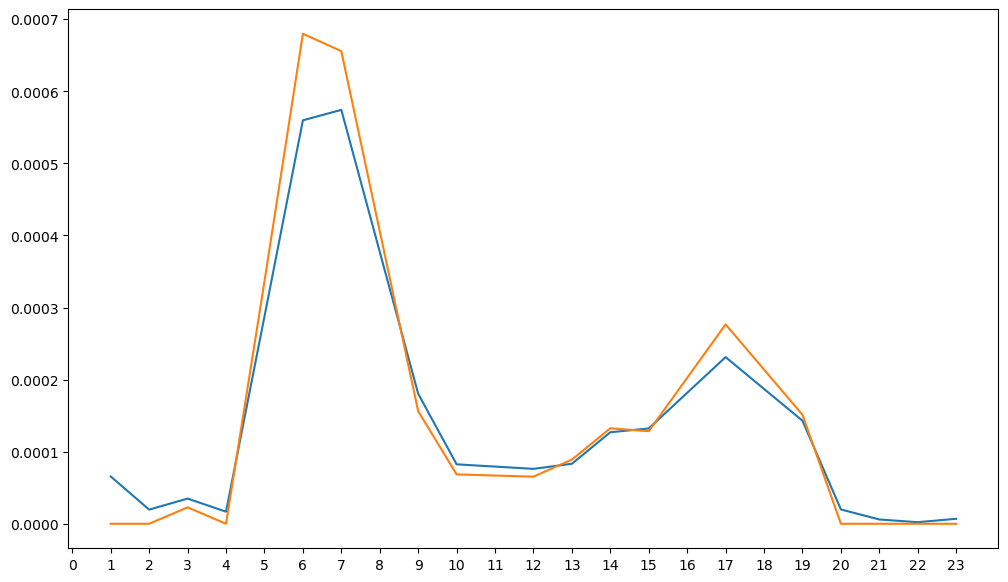

In [37]:
#Visualization
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(modelled.Hour, modelled.preds)
ax.plot(modelled.Hour, modelled.dm3)
ax.set_xticks(np.arange(0, 24, step=1))
plt.show()

The Random Forest doesn't predict quite to be relied on

<h1 style="font-size:2.5rem;color:blue;">Ridge Regression Model</h1>

In [70]:
ridge = Ridge(alpha=1)
ridge = ridge.fit(X_train_scaled_filled, y_train)
ridge.score(X_test_scaled_filled, y_test)

0.9462254208143505

In [71]:
#ridge predictions
preds_ridge = ridge.predict(X_train_scaled_filled)

In [72]:
modelled_ridge = pd.DataFrame({'preds' : preds_ridge,
                        'Hour' : X_train.Hour,
                        'dm3' : y_train.values}
                )

In [73]:
modelled_ridge = modelled_ridge.sort_values(by="Hour", ascending=True)

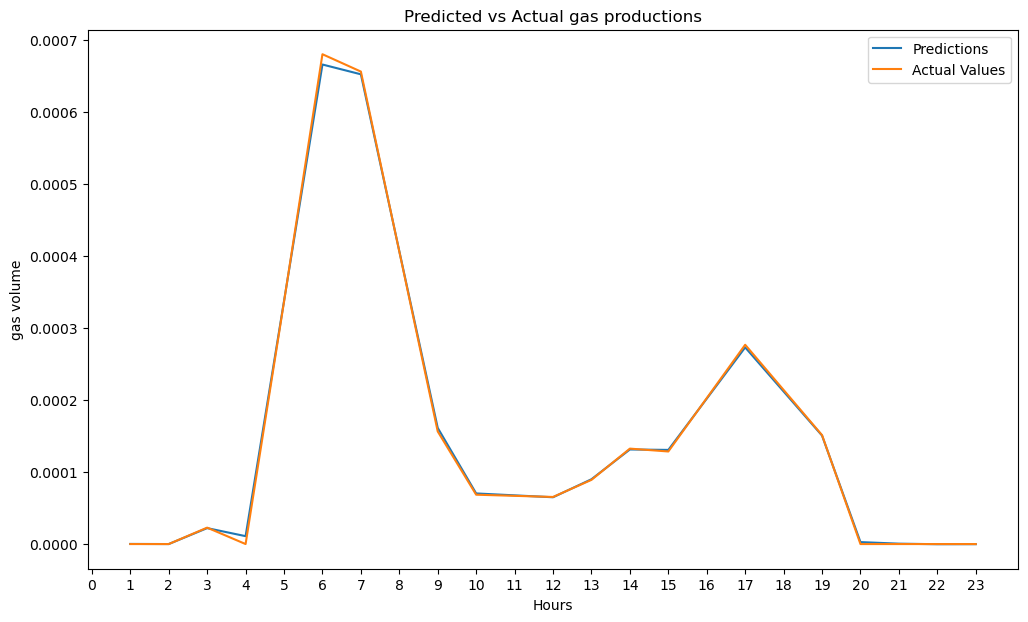

In [49]:
#Visualization
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(modelled_ridge.Hour, modelled_ridge.preds, label = "Predictions")
ax.plot(modelled_ridge.Hour, modelled_ridge.dm3, label = "Actual Values")
ax.set_xticks(np.arange(0, 24, step=1))
ax.set_ylabel("gas volume")
ax.set_xlabel("Hours")
plt.title("Predicted vs Actual gas productions")
plt.legend()
plt.show()

Ridge Model performed quite well

## Neural Network for Multi-Output Regression

In [138]:
# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense

# get the dataset
X = data_hourly_grouped

y = data_hourly_group['dm3_gas']

model = Sequential()
model.add(Dense(20, input_dim=X.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(Dense(len(y)))


model.compile(loss='mae', optimizer='adam')
    
 
X_train, X_test,y_train,  y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

model.fit(X_train, y_train, verbose=0, epochs=100)



mae = model.evaluate(X_test, y_test, verbose=0)
print(mae)


0.8750513195991516


Sequential Model had a lower  score that of Ridge Regression model

<h1 style="font-size:2.5rem;color:maroon;">Hyperparameter Tune Ridge Regression</h1>

<h1 style="font-size:2rem;color:purple;">1.1 Feature Selection</h1>

<h1 style="font-size:1.5rem;color:blue;">1.1.0Recursive Feature Elimination</h1>

In [91]:
selected_features

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

In [94]:
X = data_hourly_grouped

y = data_hourly_group['dm3_gas']


ridge = Ridge(alpha=1)
rfe = RFE(ridge, n_features_to_select= 125)  
rfe.fit(X, y)

selected_features = X.columns[rfe.support_]
rfe_data = X[selected_features]

X_train, X_test,y_train,  y_test = train_test_split(rfe_data, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

In [77]:
rfe_data = X[selected_features]

In [93]:
#X_train, X_test,y_train,  y_test = train_test_split(rfe_data, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape,  y_train.shape, y_test.shape

((19, 125), (5, 125), (19,), (5,))

In [121]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test))

#filling missing values
X_train_scaled_filled = X_train_scaled.fillna(0)
X_test_scaled_filled = X_test_scaled.fillna(0)

In [95]:
ridge = Ridge(alpha=1)
ridge = ridge.fit(X_train_scaled_filled, y_train)
ridge.score(X_test_scaled_filled, y_test)

0.9462254208143506

In [98]:
#ridge predictions
preds_ridge = ridge.predict(X_train_scaled_filled)

In [99]:
modelled_ridge = pd.DataFrame({'preds' : preds_ridge,
                        'Hour' : X_trainn.Hour,
                        'dm3' : y_train.values}
                )

In [100]:
modelled_ridge = modelled_ridge.sort_values(by="Hour", ascending=True)

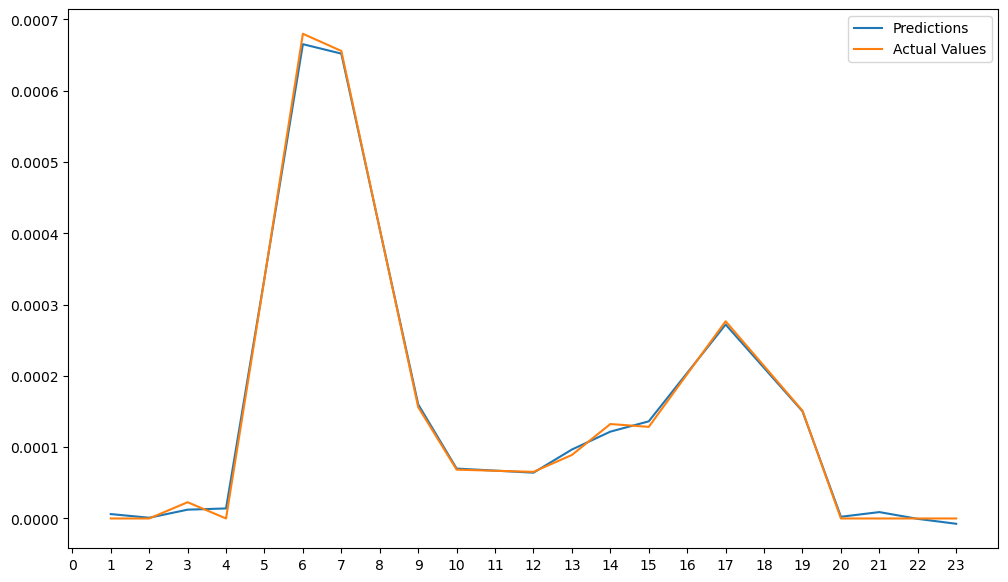

In [101]:
#Visualization
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(modelled_ridge.Hour, modelled_ridge.preds, label = "Predictions")
ax.plot(modelled_ridge.Hour, modelled_ridge.dm3, label = "Actual Values")
ax.set_xticks(np.arange(0, 24, step=1))
plt.legend()
plt.show()

<h1 style="font-size:2.5rem;color:maroon;">Creating  Input values</h1>

In [118]:
gas_temp = float(input("Gas Temperatures: "))
gas_umidity = float(input("gas humidity"))
air_temp = float(input("gair_temp"))
ground_temp = float(input("gground_temp"))
fluid_temp = float(input("fluid_temp"))

Gas Temperatures: 11
gas humidity22
gair_temp12
gground_temp15
fluid_temp23


# 

In [119]:
inputs = pd.DataFrame({'gas_temp' : [gas_temp], 'gas_umidity' : [gas_umidity],  "air_temp"  : [air_temp], "ground_temp" : [ground_temp], "fluid_temp" : [fluid_temp] })

In [105]:
inputs

,gas_temp,gas_umidity,air_temp,ground_temp,fluid_temp
0,12.0,0.22,0.45,11.0,56.0


In [106]:
data_columns = ['gas_temp', 'gas_umidity',"air_temp","ground_temp", "fluid_temp"]
lags = 24
for feature in data_columns:
    for lag in range(1, lags + 1):
        inputs[f'{feature}_lag_{lag}'] = inputs[feature].shift(lag)

In [107]:
inputs

,gas_temp,gas_umidity,air_temp,ground_temp,fluid_temp,gas_temp_lag_1,gas_temp_lag_2,gas_temp_lag_3,gas_temp_lag_4,gas_temp_lag_5,...,fluid_temp_lag_15,fluid_temp_lag_16,fluid_temp_lag_17,fluid_temp_lag_18,fluid_temp_lag_19,fluid_temp_lag_20,fluid_temp_lag_21,fluid_temp_lag_22,fluid_temp_lag_23,fluid_temp_lag_24
0,12.0,0.22,0.45,11.0,56.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
inputs = inputs.fillna(0)

In [109]:
inputs_scaled = scaler.fit_transform(inputs)

In [110]:
inputs_scaled

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [111]:
preed = ridge.predict(inputs_scaled)

In [112]:
preed

array([0.0001454])

In [116]:
def prediction(inputs):
    data_columns = ['gas_temp', 'gas_umidity',"air_temp","ground_temp", "fluid_temp"]
    lags = 24
    for feature in data_columns:
        for lag in range(1, lags + 1):
            inputs[f'{feature}_lag_{lag}'] = inputs[feature].shift(lag)
    inputs = inputs.fillna(0)
    inputs_scaled = scaler.fit_transform(inputs)
    preed = ridge.predict(inputs_scaled)
    return preed

In [117]:
preed

array([0.0001454])